In [ ]:
# torch with cuda
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from ultralytics import YOLO
import torch
import os

# Load a model
# model = YOLO("best.onnx")
yolo_model = YOLO("yolo11n.pt")

path = os.path.join(os.path.abspath("."),"License Plate Recognition.v6i.yolov11.zip")

# # Train the model
# train_results = model.train(
#     data=path,  # path to dataset YAML
#     epochs=100,  # number of training epochs
#     # workers=100,
#     # patience=20,
#     imgsz=640,  # training image size
#     device="cuda" if torch.cuda.is_available() else "cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
# )

# # Evaluate model performance on the validation set
# metrics = model.val()

# # Export the model to ONNX format
# path = model.export(format="onnx")  # return path to exported model

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from ultralytics import YOLO
from ultralytics.engine.results import Boxes, Results
import os
import cv2
from matplotlib import pyplot as plt
from safe_video import NumberPlateRecognition
import numpy as np
import torch

yolo_model_path = os.path.join(os.path.abspath("."), "models", "yolo11n.pt")
yolo_model = YOLO(yolo_model_path, task='detect')
plate_model_path = os.path.join(os.path.abspath("."),"models","first10ktrain","weights","best.pt")
plate_model = YOLO(plate_model_path, task='detect')
rec = NumberPlateRecognition()



0: 448x640 14 cars, 3 traffic lights, 15.0ms
Speed: 3.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 License_Plate, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 License_Plates, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 1 License_Plate, 18.4ms
Speed: 2.0ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x608 1 License_Plate, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 512x640 1 License_Plate, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 2 License_Plates, 18.0ms
Speed: 2.3ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 License_Plate, 19.0ms
Speed: 2.0ms preproce

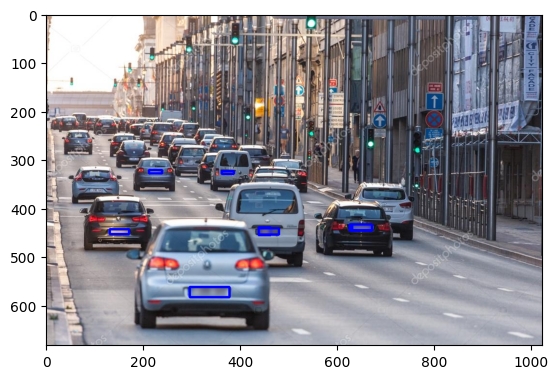

In [28]:
image = cv2.imread("example.jpg")

image = image[:, :, ::-1]
box, conf, _, _ = rec.chained_detection(image, "car").tuple()
result = rec.blur_image(image, box)
plt.imshow(result)
plt.show()

In [ ]:
display_width = 1200
display_height = 800
frame_counter = 0
cap = cv2.VideoCapture(r"c:\Users\Emre\Videos\test2.mp4")

while cap.isOpened():
    success, frame = cap.read()
    if success:
        frame_counter += 1
        if frame_counter % 3 != 0:
            continue
        results = yolo_model.track(frame, persist=True,  tracker="bytetrack.yaml" ) # yolo_model(frame, imgsz=320 ,verbose = False)
        # display(results[0].boxes)
        #annotated_frames = results[0].plot() if results[0] is not None else frame
        
        #frames = results[0].plot() if results[0] is not None else Boxes()
        boxes = results[0].boxes if results[0] is not None else Boxes()

        if boxes:
            for box in boxes.data:
                x1, y1, x2, y2 = map(int, box[:4])  
                conf = box[5]
                #cls = int(box[6])
                
                
                if conf > 0.01:  
                    cropeed_image = frame[y1:y2, x1:x2]
                    
                    plate_results  = plate_model.track(cropeed_image, tracker="bytetrack.yaml" )[0] #persist=True, conf=conf, iou=0.5, show=True, tracker="bytetrack.yaml"
                    plate_boxes  = plate_results.boxes.cpu().numpy()
                    if plate_boxes is not None:
                        for plate_box in plate_boxes.data:
                            # coordinates of the plate box
                            px1, py1, px2, py2 = map(int, plate_box[:4])
                            
                            
                            tx1, ty1, tx2, ty2 = px1 + x1, py1 + y1, px2 + x1, py2 + y1
                            plate_region = frame[ty1:ty2, tx1:tx2]
                            grrr = cv2.GaussianBlur(plate_region, (25, 25), 0)
                            frame[ty1:ty2, tx1:tx2] = grrr
                            
                            cv2.rectangle(frame, (tx1, ty1), (tx2, ty2), (0, 255, 0), 5)
  
                        

                            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 5)
                    
        resized_frame = cv2.resize(frame, (display_width, display_height))
        
        cv2.imshow("Tracking", resized_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()
                
                
    


0: 384x640 5 cars, 23.0ms
Speed: 2.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 License_Plate, 20.0ms
Speed: 1.0ms preprocess, 20.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 (no detections), 20.0ms
Speed: 3.0ms preprocess, 20.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 (no detections), 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 224x640 (no detections), 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 416x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 2 cars, 27.0ms
Speed: 2.0ms preprocess, 27.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 License_Plate, 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 2.0ms po